In [1]:
# Imports
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.models import Sequential

In [2]:
# Don't run this block of code if you aren't using Tensorflow-GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [3]:
def normalize(values):
    """This function takes as input a set of values and outputs the normalized values, their mean and their standard
    deviation.

    :param values: Integer or float values that we want to normalize.
    :returns values: Normalized values.
             mean: Mean of the values.
             std: Standard deviation of the values."""

    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std

    return values, mean, std

In [4]:
def create_sequences(values, time_steps):
    """This function takes as input a set of values and outputs the values in a time-series format.

    :param values: Integer or float values that we want to convert to time-series format.
    :param time_steps: Integer indicating the length of the time-series.
    :return output: An array of time-series values."""

    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i: (i + time_steps)])

    return np.expand_dims(output, axis=2)

In [5]:
def get_anomaly_indices(threshold, train_loss):
    """This function returns the indices of the anomalies.
    :param threshold: Integer or float indicating the threshold we above which we would consider data points to be
                      anomalies.
    :param train_loss: The training loss.
    :return: indices: The indices of the anomalies."""

    anomalies = (train_loss > threshold).tolist()
    flat_list = []
    for sublist in anomalies:
        for item in sublist:
            flat_list.append(item)
    anomaly_indices = [i for i, x in enumerate(flat_list) if x == True]

    return anomaly_indices

In [6]:
def compare(dataset, anomaly_indices):
    """This function plots the comparison of the anomalies with the original dataset.

    :param dataset: The dataset on which we want to make a comparison.
    :param anomaly_indices: The indices of the anomalies in the dataset."""

    anomalies = dataset.iloc[anomaly_indices]
    dataset_copy = dataset.copy()
    dataset_copy['value'] = None
    combine = anomalies.combine_first(dataset_copy)
    dates = dataset["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = dataset["value"].to_list()
    plt.figure(figsize=(15, 7))
    plt.plot(dates, values, label="test data")  # Change
    dates = combine["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = combine["value"].to_list()
    plt.plot(dates, values, label="anomalies", color="r")  # Change
    plt.legend()
    plt.show()

In [7]:
def dense(x__train):
    """This function creates the Dense auto-encoder model.

    :param x__train: The training data. It is used to set the input shape.
    :return autoencoder: The autoencoder model."""

    inputs = Input(shape=(x__train.shape[1], x__train.shape[2]))

    # Encoding
    x = Flatten()(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    encoded = Dense(128, activation='relu')(x)

    # Decoding
    x = Dense(128, activation='relu')(encoded)
    x = Dense(64, activation='relu')(x)
    x = Dense(32)(x)
    decoded = Reshape((32, 1))(x)

    autoencoder = Model(inputs, decoded)

    return autoencoder

In [8]:
def lstm_modify(threshold1, threshold2, train_loss):
    """This function returns the anomaly indices for a certain range of MAE loss.

    :param threshold1: Integer or float representing the first threshold value.
    :param threshold2: Integer or float representing the second threshold value.
    :param train_loss: Training loss.
    :return anomaly_indices: Indices of anomalies in the dataset."""

    anomalies = (threshold1 < train_loss).tolist()
    flat_list = []

    for sublist in anomalies:
        for item in sublist:
            flat_list.append(item)
    indices1 = [i for i, x in enumerate(flat_list) if x == True]

    anomalies2 = (train_loss < threshold2).tolist()
    flat_list2 = []

    for sublist2 in anomalies2:
        for item2 in sublist2:
            flat_list2.append(item2)
    indices2 = [i for i, x in enumerate(flat_list2) if x == True]

    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3

    anomaly_indices = intersection(indices1, indices2)

    return anomaly_indices

In [9]:
cpu_utilization = pd.read_csv('ec2_cpu_utilization_5f5533.csv')

# Statistics about the dataset.
print('\nCPU Utilization Dataset Shape:', cpu_utilization.shape)
print('\nFirst 5 rows of the CPU Utilization Dataset:\n', cpu_utilization.head())
print('\nCPU Utilization Dataset description:\n', cpu_utilization.describe())


CPU Utilization Dataset Shape: (4032, 2)

First 5 rows of the CPU Utilization Dataset:
              timestamp   value
0  2014-02-14 14:27:00  51.846
1  2014-02-14 14:32:00  44.508
2  2014-02-14 14:37:00  41.244
3  2014-02-14 14:42:00  48.568
4  2014-02-14 14:47:00  46.714

CPU Utilization Dataset description:
              value
count  4032.000000
mean     43.110372
std       4.303565
min      34.766000
25%      39.296000
50%      42.918000
75%      46.006000
max      68.092000


### Notice there are two obvious spikes, which means the cpu utilization reaches beyond 60%. This is the offical red line for Amazon. Therefore we should also detect the two peaks.

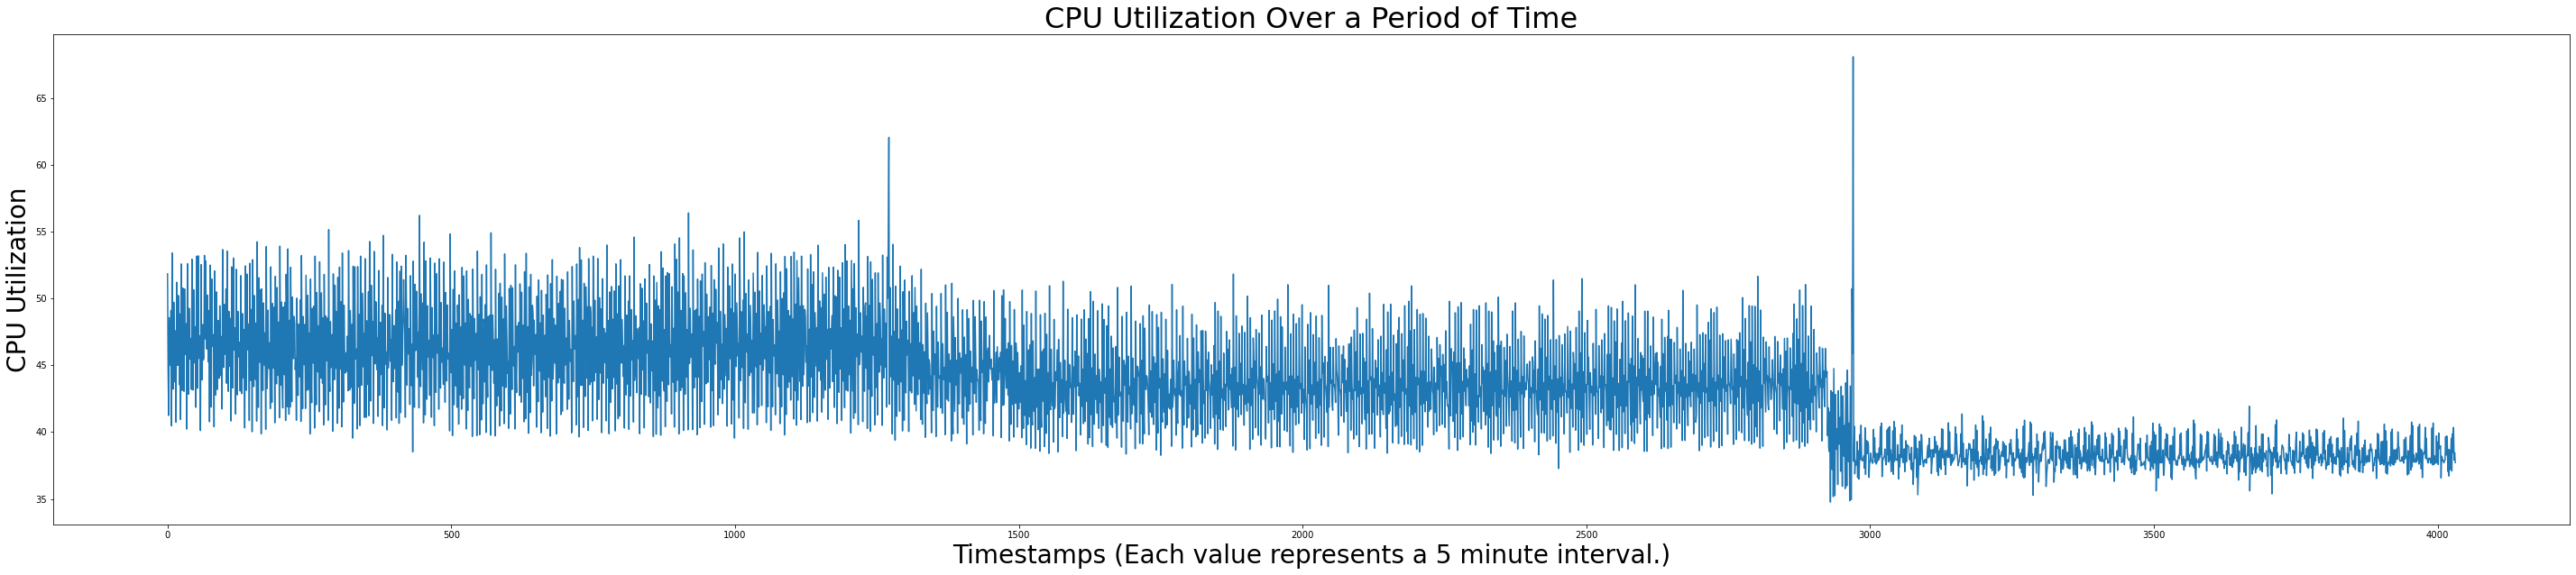

In [10]:
# Visualize the data.
plt.figure(figsize=(50, 10))
plt.plot(cpu_utilization['value'].values)
plt.xlabel('Timestamps (Each value represents a 5 minute interval.)', fontsize=28)
plt.ylabel('CPU Utilization', fontsize=28)
plt.title('CPU Utilization Over a Period of Time', fontsize=32)
plt.show()

In [11]:
cpu_utilization_values = cpu_utilization.value.to_list()
# print(cpu_utilization_values)

In [12]:
normalized_cpu_utilization_values, training_mean, training_std = normalize(cpu_utilization_values)

### Just like any other time series problems we also use timesteps or window.

In [13]:
x_train = create_sequences(normalized_cpu_utilization_values, time_steps=32)
print("Training data shape: ", x_train.shape)

Training data shape:  (4000, 32, 1)


## 1. Build a Autoencoder model for predicting a sequence of values. Show 3 different Autoencoder setups (e.g. using Dense/LSTM/Conv1D layers).

### The following case is Conv1D model. Notice that it needs TF 2.3.0 otherwise it may report error when it deals with Conv1DTranspose.

In [14]:
# Conv1D based auto-encoder model.
model = keras.Sequential([layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
                          layers.Conv1D(filters=18, kernel_size=7, padding="same", strides=2, activation="relu"),
                          layers.Dropout(rate=0.2),
                          layers.Conv1D(filters=9, kernel_size=7, padding="same", strides=2, activation="relu"),
                          layers.Conv1DTranspose(filters=9, kernel_size=7, padding="same", strides=2,
                                                 activation="relu"),
                          layers.Dropout(rate=0.2),
                          layers.Conv1DTranspose(filters=18, kernel_size=7, padding="same", strides=2,
                                                 activation="relu"),
                          layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 18)            144       
_________________________________________________________________
dropout (Dropout)            (None, 16, 18)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 9)              1143      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 16, 9)             576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 9)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 32, 18)            1152      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 32, 1)             1

In [15]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/50
29/29 [==============================] - 0s 11ms/step - loss: 0.8239 - val_loss: 0.2166
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 0.4906 - val_loss: 0.1985
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 0.3025 - val_loss: 0.1387
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2500 - val_loss: 0.1201
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2238 - val_loss: 0.1018
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2063 - val_loss: 0.0839
Epoch 7/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1880 - val_loss: 0.0742
Epoch 8/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1736 - val_loss: 0.0640
Epoch 9/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1592 - val_loss: 0.0606
Epoch 10/50
29/29 [==============================] - 0s 3ms/step - loss: 0.1475 - val_loss: 0.0589
Epoch 11/50
29/29 

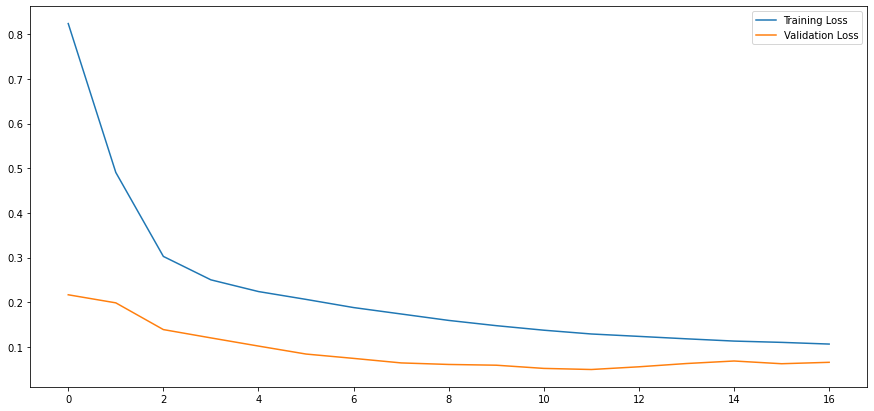

In [16]:
# Plotting the training and validation losses.
plt.figure(figsize=(15, 7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### From the MAE loss distribution below we can determine a good threshold, which can filter most of reasonable loss.

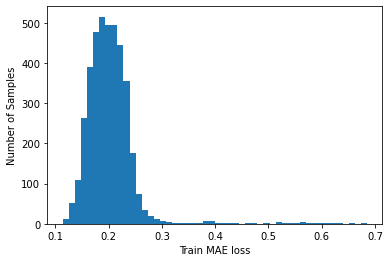

In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of Samples")
plt.show()

### We reconstruct the first window to see how well it works. 

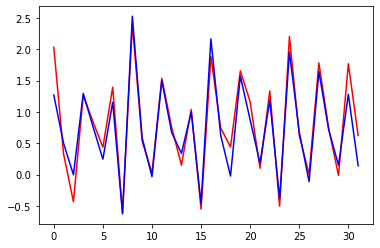

In [18]:
plt.plot(x_train[0],'red')
plt.plot(x_train_pred[0],'blue')
plt.show()

### Plotting the comparison of the dataset with the anomalies.

c:\program files\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


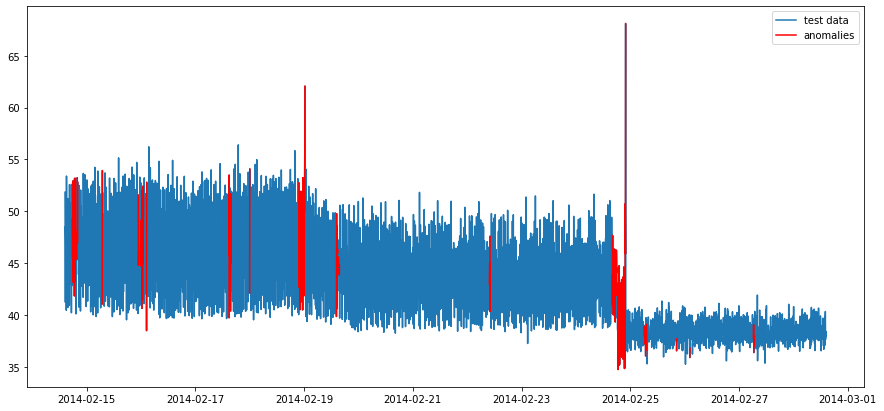

In [19]:
# Plotting the comparison of the dataset with the anomalies.
anomalies_index = get_anomaly_indices(threshold=0.245, train_loss=train_mae_loss)
compare(cpu_utilization, anomalies_index)

### The next model Is LSTM based autoencoder.

In [20]:
model2 = Sequential()
model2.add(LSTM(128, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
model2.add(LSTM(64, activation='relu', return_sequences=False))
model2.add(RepeatVector(x_train.shape[1]))
model2.add(LSTM(64, activation='relu', return_sequences=True))
model2.add(LSTM(128, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(x_train.shape[2])))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 32, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [21]:
history2 = model2.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1).history

Epoch 1/50
29/29 [==============================] - 6s 205ms/step - loss: 0.7211 - val_loss: 0.6352
Epoch 2/50
29/29 [==============================] - 6s 197ms/step - loss: 0.5712 - val_loss: 0.2031
Epoch 3/50
29/29 [==============================] - 6s 192ms/step - loss: 0.5534 - val_loss: 0.1390
Epoch 4/50
29/29 [==============================] - 5s 188ms/step - loss: 0.5307 - val_loss: 0.0935
Epoch 5/50
29/29 [==============================] - 6s 193ms/step - loss: 0.5186 - val_loss: 0.0781
Epoch 6/50
29/29 [==============================] - 5s 189ms/step - loss: 0.5112 - val_loss: 0.0512
Epoch 7/50
29/29 [==============================] - 6s 190ms/step - loss: 0.5074 - val_loss: 0.0502
Epoch 8/50
29/29 [==============================] - 5s 184ms/step - loss: 0.5062 - val_loss: 0.0490
Epoch 9/50
29/29 [==============================] - 5s 185ms/step - loss: 0.5054 - val_loss: 0.0499
Epoch 10/50
29/29 [==============================] - 5s 184ms/step - loss: 0.5053 - val_loss: 0.0555

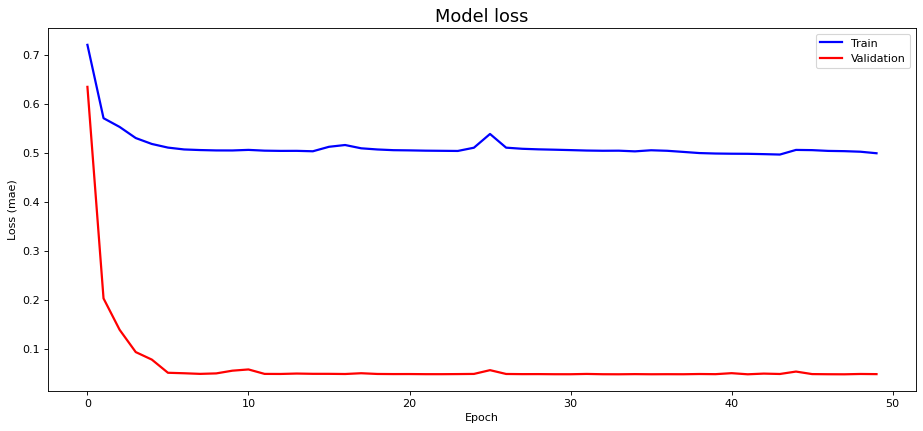

In [22]:
# Plotting the training and validation losses.
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history2['loss'], 'b', label='Train', linewidth=2)
ax.plot(history2['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### The curve of this MAE loss distribution looks weird because it has two bell curves (with overlap). 

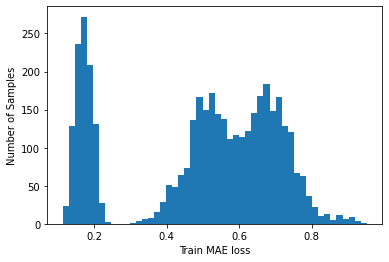

In [23]:
x_train_pred2 = model2.predict(x_train)
train_mae_loss2 = np.mean(np.abs(x_train_pred2 - x_train), axis=1)

plt.hist(train_mae_loss2, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of Samples")
plt.show()

### We select the threshold which filters most of smaller MAE loss and it performs not as good as Conv1D mode.

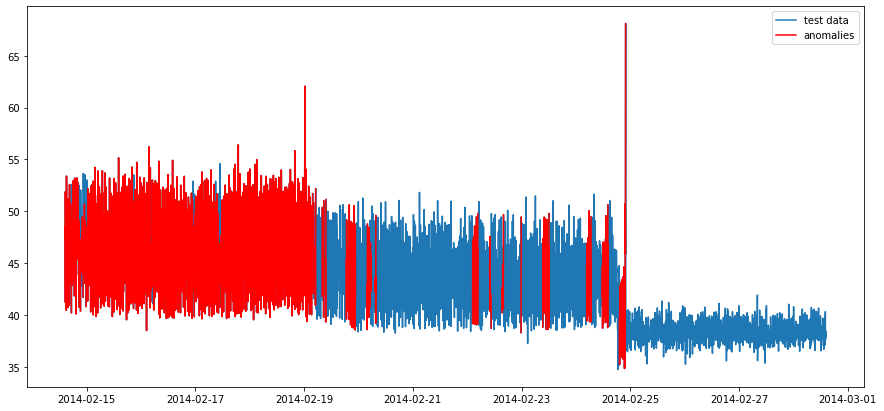

In [24]:
anomalies_index2 = get_anomaly_indices(threshold=0.6, train_loss=train_mae_loss2)
compare(cpu_utilization, anomalies_index2)

### We select only the second bell curve and find that the second curve represents the range of dataset which has higher values. 0.2 is the demarcation point between first and second bell curve.

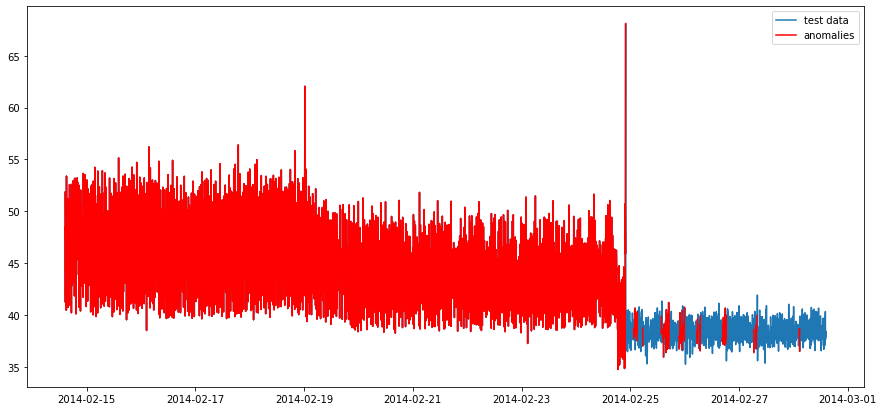

In [25]:
anomalies_index3_1 = get_anomaly_indices(threshold=0.2, train_loss=train_mae_loss2)
compare(cpu_utilization, anomalies_index3_1)

### Then we define a new function which can detect a certain range of MAE loss.

### We pick the first bell curve (0.1~0.19) and find that it represents the range of lower values (which is actually cpu utilization) in original dataset.

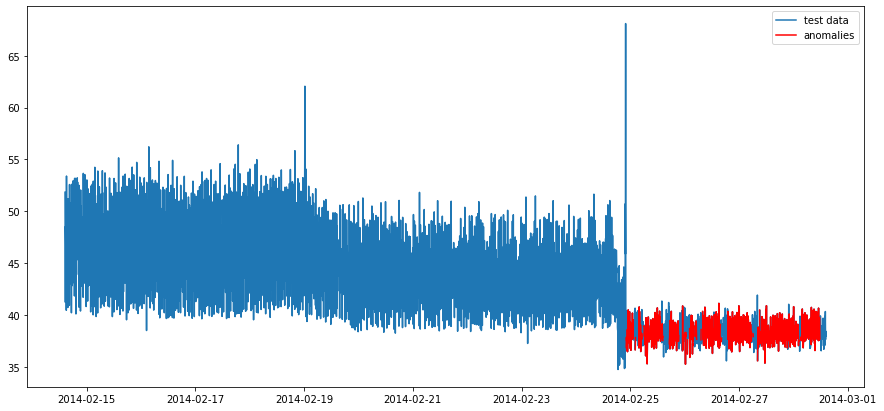

In [26]:
anomalies_index3_2 = lstm_modify(threshold1=0.1, threshold2=0.19, train_loss=train_mae_loss2)
compare(cpu_utilization, anomalies_index3_2)

### We can guess this autoencoder learns two normal behaviors.

### The last one is dense model.

In [27]:
model3 = dense(x_train)
model3.compile(optimizer='adam', loss='mae')
model3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [28]:
history3 = model3.fit(x_train, x_train, epochs=50, batch_size=128, validation_split=0.1).history

Epoch 1/50
29/29 [==============================] - 0s 4ms/step - loss: 0.6428 - val_loss: 0.3087
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4032 - val_loss: 0.1781
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.3254 - val_loss: 0.1650
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2887 - val_loss: 0.1633
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2677 - val_loss: 0.1571
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2535 - val_loss: 0.1582
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2442 - val_loss: 0.1551
Epoch 8/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2342 - val_loss: 0.1463
Epoch 9/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2276 - val_loss: 0.1449
Epoch 10/50
29/29 [==============================] - 0s 2ms/step - loss: 0.2215 - val_loss: 0.1401
Epoch 11/50
29/29 [

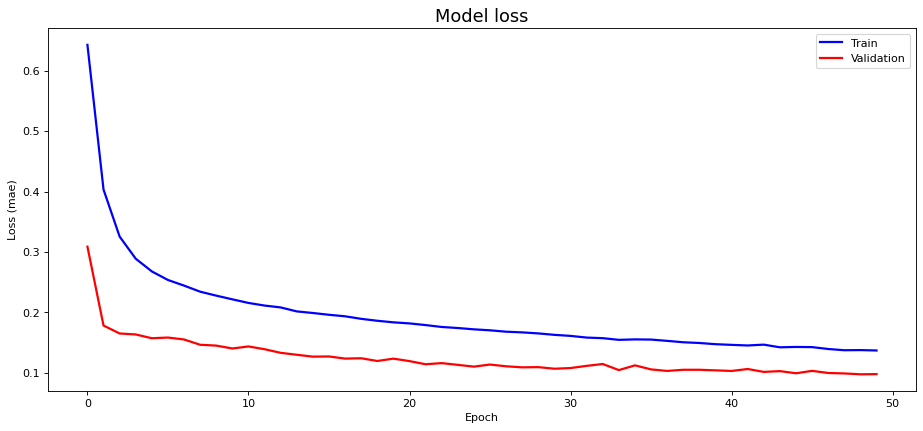

In [29]:
# Plotting the training and validation losses.
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history3['loss'], 'b', label='Train', linewidth=2)
ax.plot(history3['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

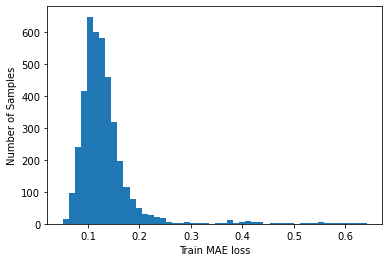

In [30]:
x_train_pred3 = model3.predict(x_train)
train_mae_loss3 = np.mean(np.abs(x_train_pred3 - x_train), axis=1)

plt.hist(train_mae_loss3, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of Samples")
plt.show()

### We can see the dense mode works fairly well too.

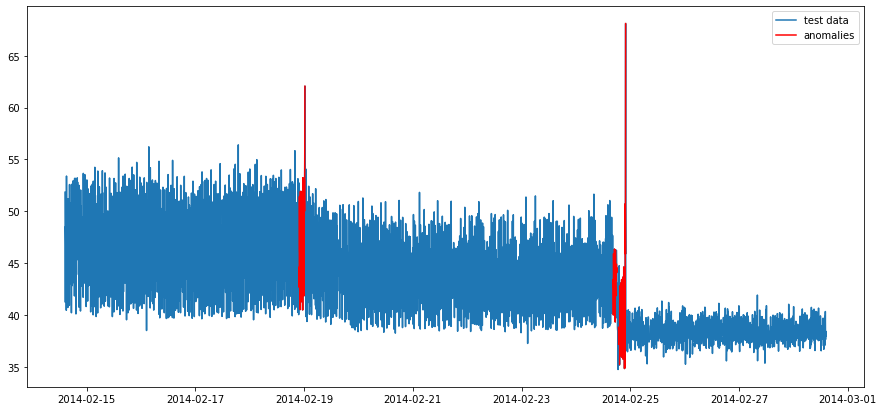

In [31]:
anomalies_index4 = get_anomaly_indices(threshold=0.28, train_loss=train_mae_loss3)
compare(cpu_utilization, anomalies_index4)

### All the results and graphs are provided above. (Note we do not need to provide accuracy in a reconstruction task) We can find that the Conv1D and dense modes autoencoder work fairly well in this test. They can reconstruct the original dataset based on the 'normal behavior' and find the anomalies. However the LSTM based autoencoder performs differently. It outputs a MAE loss distribution which has two bell curves in it (with overlap) and after detecting different thresholds we find that the different curves represent different ranges of values (cpu utilization) in the original dataset. After applying different set up we find that with smaller structure the LSTM based auto-encoder will produce more bell curves, which means It cannot identify more similar behavior as the same 'normal' behavior. We can explore more in this area.